In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [20]:
import os
# Root directory for dataset

# Construct the file path to the parent folder
parent_folder = os.path.dirname(os.getcwd())
dataroot = os.path.join(parent_folder, 'fc_matrices/schaefer')

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 30

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

/rds/general/user/ljn19/home/big/container/psilocybrain
/rds/general/user/ljn19/home/big/container/psilocybrain/fc_matrices/schaefer


In [21]:
import sys
sys.path.append('../')

from utils import BrainGraphDataset

In [22]:
import os
# We can use an image folder dataset the way we have it setup.
# Create the dataset

file_path = os.path.join(parent_folder, os.path.join(parent_folder, 'annotations.csv'))

dataset = BrainGraphDataset(img_dir=dataroot,
                            annotations_file=file_path,
                           transform=None, setting='upper_triangular')

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

/rds/general/user/ljn19/home/big/container/psilocybrain/fc_matrices/schaefer


In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, 0.0, 0.02)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0.0)

In [24]:
class GeneratorLinear(nn.Module):
    def __init__(self, ngpu):
        super(GeneratorLinear, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(nz, 1028),
            nn.ReLU(False),
            nn.Linear(1028, 2048),
            nn.ReLU(False),
            nn.Linear(2048, 2048),
            nn.ReLU(False),
            nn.Linear(2048, 4950),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [25]:
# Create the generator
netG = GeneratorLinear(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

GeneratorLinear(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=1028, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1028, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=4950, bias=True)
    (7): Tanh()
  )
)


In [26]:
class DiscriminatorLinear(nn.Module):
    def __init__(self, ngpu):
        super(DiscriminatorLinear, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(4950, 2048),
            nn.LeakyReLU(True),
            nn.Linear(2048, 512),
            nn.LeakyReLU(True),
            nn.Linear(512, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 8),
            nn.LeakyReLU(True),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [27]:
# Create the Discriminator
netD = DiscriminatorLinear(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DiscriminatorLinear(
  (main): Sequential(
    (0): Linear(in_features=4950, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=512, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=64, out_features=8, bias=True)
    (7): LeakyReLU(negative_slope=True)
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [28]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [29]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device).float()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/200][0/2]	Loss_D: 1.3863	Loss_G: 0.6935	D(x): 0.5000	D(G(z)): 0.4999 / 0.4998
[1/200][0/2]	Loss_D: 1.3490	Loss_G: 0.6833	D(x): 0.5232	D(G(z)): 0.5040 / 0.5049
[2/200][0/2]	Loss_D: 1.3267	Loss_G: 0.6273	D(x): 0.5642	D(G(z)): 0.5296 / 0.5341
[3/200][0/2]	Loss_D: 1.4743	Loss_G: 0.5444	D(x): 0.6179	D(G(z)): 0.6292 / 0.5802
[4/200][0/2]	Loss_D: 1.4964	Loss_G: 0.6503	D(x): 0.5652	D(G(z)): 0.6037 / 0.5219
[5/200][0/2]	Loss_D: 1.3693	Loss_G: 0.8266	D(x): 0.5121	D(G(z)): 0.5034 / 0.4375
[6/200][0/2]	Loss_D: 1.3300	Loss_G: 0.9655	D(x): 0.4761	D(G(z)): 0.4444 / 0.3808
[7/200][0/2]	Loss_D: 1.4000	Loss_G: 0.9039	D(x): 0.4432	D(G(z)): 0.4434 / 0.4050
[8/200][0/2]	Loss_D: 1.4729	Loss_G: 0.7529	D(x): 0.4424	D(G(z)): 0.4816 / 0.4710
[9/200][0/2]	Loss_D: 1.4290	Loss_G: 0.7187	D(x): 0.4725	D(G(z)): 0.4930 / 0.4874
[10/200][0/2]	Loss_D: 1.3741	Loss_G: 0.7133	D(x): 0.5000	D(G(z)): 0.4939 / 0.4900
[11/200][0/2]	Loss_D: 1.3248	Loss_G: 0.7041	D(x): 0.5286	D(G(z)): 0.4970 / 0.4946


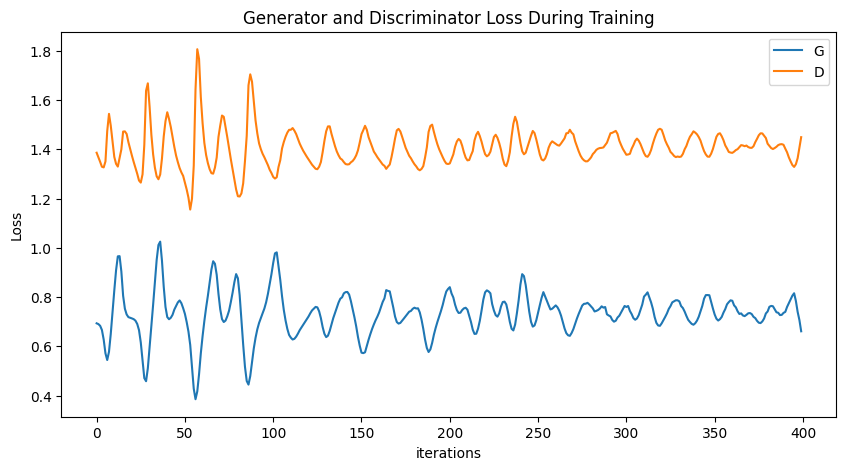

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
noise = torch.randn(155, nz, device=device)
graphs = netG.forward(noise)

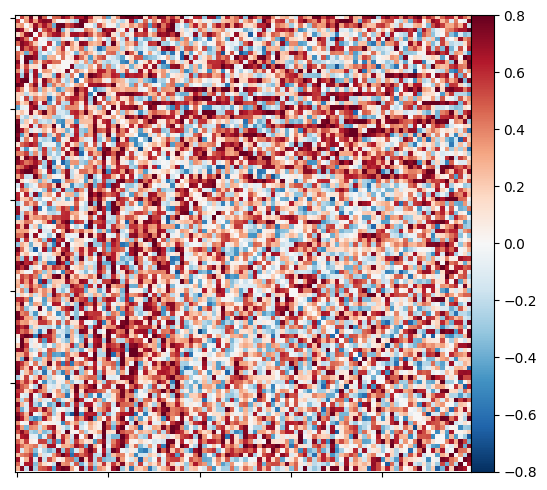

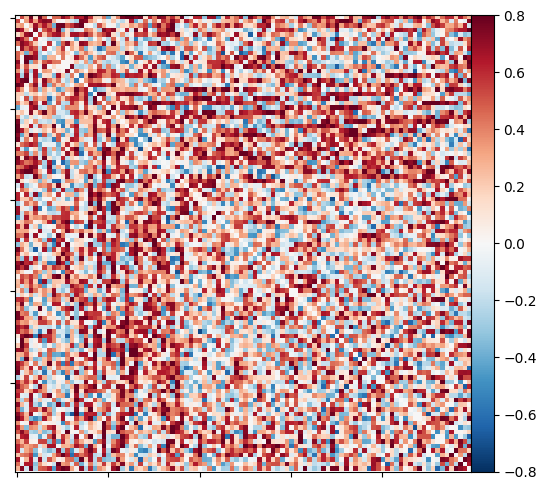

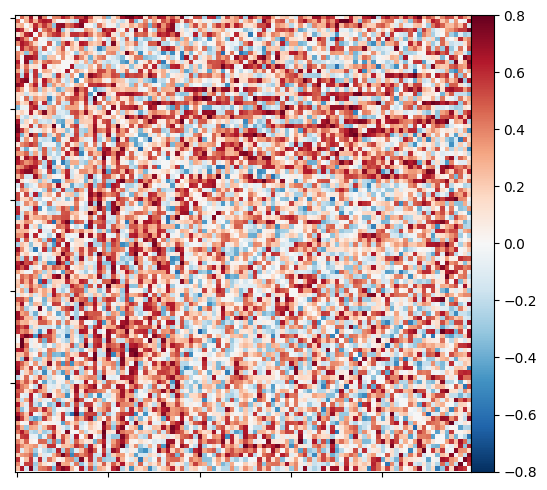

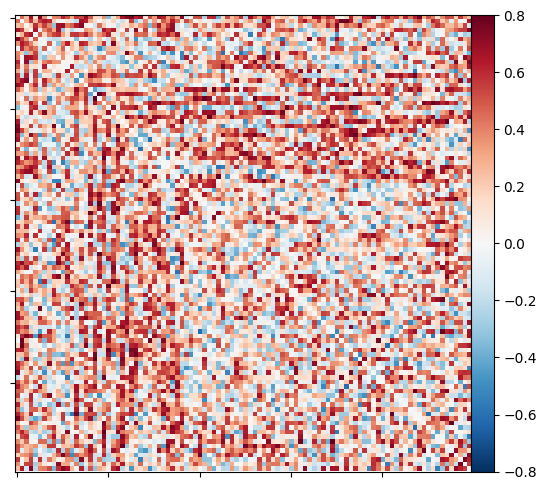

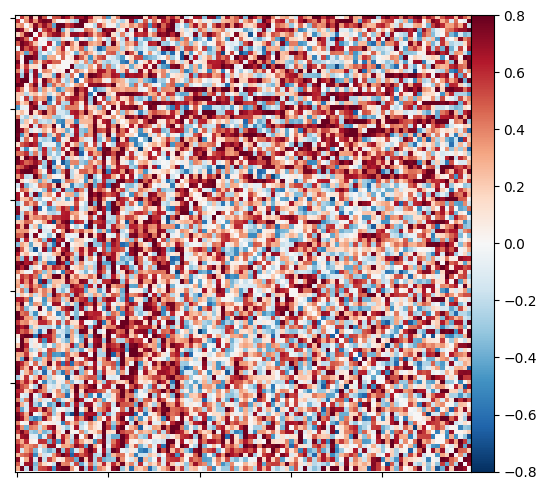

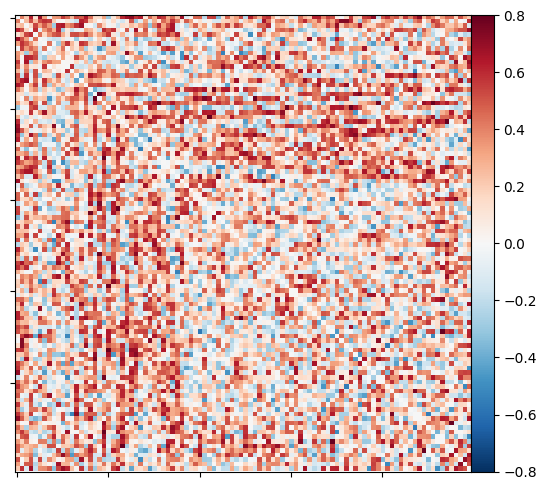

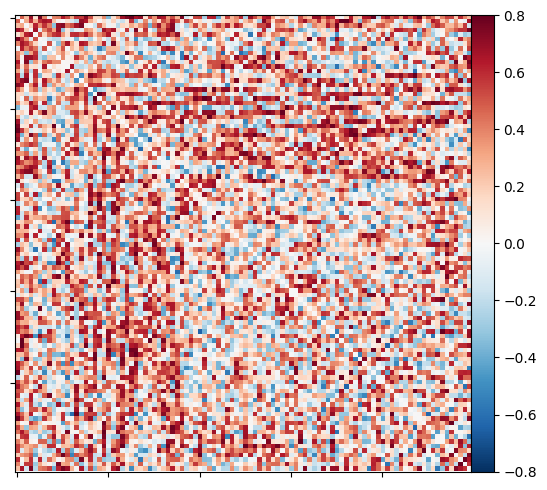

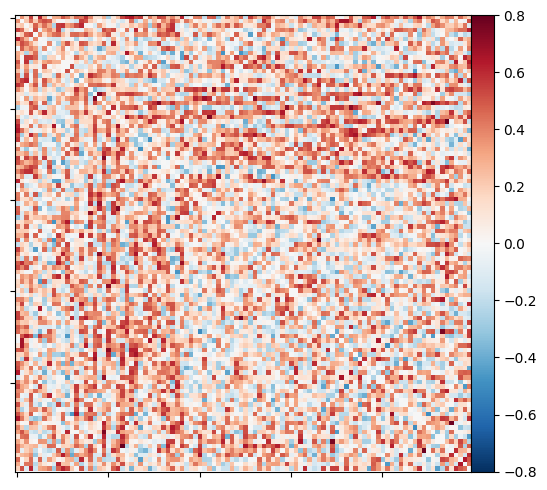

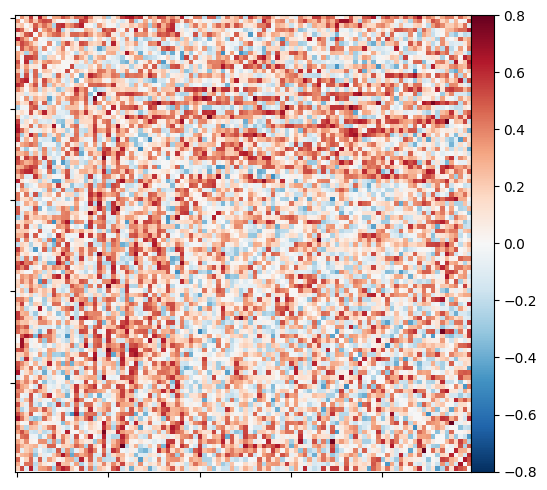

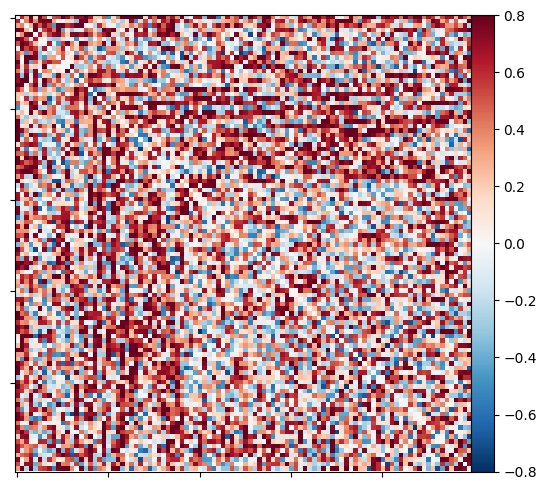

In [32]:
from nilearn import plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from utils import make_edge_index

edge_index = make_edge_index(100)

for graph in graphs[:10]:
    recon = torch.zeros((100, 100))
    
    for i in range(edge_index.shape[1]):
        recon[edge_index[0,i], edge_index[1,i]] = graph[i]
        recon[edge_index[1,i], edge_index[0,i]] = graph[i]
    
    plotting.plot_matrix(recon.detach(), colorbar=True,
                        vmax=0.8, vmin=-0.8)
    